<a href="https://colab.research.google.com/github/navas017/Grupo40-Practica1/blob/main/Practica1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1.INTRODUCCIÓN** 

### Importación de librerías 

In [ ]:
import pandas as pd
import numpy as np
import urllib.request
import bz2
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
import math
import time

# **2.ANÁLISIS EXPLORATORIO DE DATOS (EDA)**

# **3.PROCESAMIENTO DE DATOS**

Lectura de archivos

In [ ]:
# Aprendizaje
disp_df = pd.read_csv("/content/drive/MyDrive/Aprendizaje Automático/Datos/disp_st40ns1.txt.bz2",
 compression="bz2",
 index_col=0)

# Test
comp_df = pd.read_csv("/content/drive/MyDrive/Aprendizaje Automático/Datos/comp_st40ns1.txt.bz2",
 compression="bz2",
 index_col=0)

**Normalización de valores**

Se lleva a cabo una normalización de los datos de entrada debido a que al tener cada variable un rango distinto, en algoritmos como el KNN las distancias no son equiparables.

In [ ]:
# Seleccionar todas las columnas a normalizar
cols_to_norm_disp = disp_df.columns
cols_to_norm_comp = comp_df.columns

# Maximos y minimos para cada columna
dispMaxCol = disp_df[cols_to_norm_disp].max()
dispMinCol = disp_df[cols_to_norm_disp].min()

compMaxCol = comp_df[cols_to_norm_comp].max()
compMinCol = comp_df[cols_to_norm_comp].min()

# Escalar los valores de las columnas en el rango [0, 1]
disp_norm = (disp_df[cols_to_norm_disp] - dispMinCol) / (dispMaxCol - dispMinCol)
comp_norm = (comp_df[cols_to_norm_comp] - compMinCol) / (compMaxCol - compMinCol)

# Desnormalizar valor
disp_desnorm = disp_norm[cols_to_norm_disp] * (dispMaxCol - dispMinCol) + dispMinCol
comp_desnorm = comp_norm[cols_to_norm_comp] * (compMaxCol - compMinCol) + compMinCol

**Creación de conjuntos**

Los datos se dividen en dos conjuntos, el de entrenamiento, con el que se entrenará el modelo y el de test, con el que se evaluará el modelo.

El conjunto de entrenamiento a su vez se divide en dos, el conjunto de entrenamiento usado para construir modelos con distintos valores de hiperparámetros y el de validación, el cúal se usa para evaluar estos modelos generados.  

In [ ]:
# Conjunto de datos no normalizados
train = disp_df.iloc[:3650]
test = disp_df.iloc[3650:]

# Tamaños de los conjuntos de datos
#n_train = train.shape[0]
#n_test = test.shape[0]
n_train = 2555
n_valid = 1095

# Conjunto de datos normalizados
train_norm = disp_norm.iloc[:3650]
test_norm = disp_norm.iloc[3650:]

# Conjunto de datos normalizados partidos
train_norm_train = disp_norm.iloc[:2555]
train_norm_val = disp_norm.iloc[2555:3650] 

Predefined Split para optimización de parámetros

In [ ]:
selector = [-1] * n_train + [0] * n_valid
cv = PredefinedSplit(selector)
split = cv.get_n_splits(disp_df)

Randomización de las filas en los ficheros de train y test y valores de entrenamiento

In [ ]:
# Para la randomizacion de filas se usa la semilla 100429142
train_random = train.sample(frac=1, random_state=100429142).reset_index(drop=True)
test_random = test.sample(frac=1, random_state=100429142).reset_index(drop=True)

# Randomizacion de conjuntos normalizados
train_random_norm = train_norm.sample(frac=1, random_state=100429142).reset_index(drop=True)
test_random_norm = test_norm.sample(frac=1, random_state=100429142).reset_index(drop=True)

# Separa las variables independientes (X) de la variable dependiente (y)
X_train = train_random.iloc[:, :-1]
Y_train = train_random.iloc[:, -1]

# Variables de conjunto de datos normalizado
X_train_norm = train_random_norm.iloc[:, :-1]
Y_train_norm = train_random_norm.iloc[:, -1]

# Variables de conjunto de datos normalizado partidos
X_train_train_norm = train_norm_train.iloc[:, :-1]
X_train_val_norm = train_norm_val.iloc[:, :-1]
Y_train_train_norm = train_norm_train.iloc[:, -1]
Y_train_val_norm = train_norm_val.iloc[:, -1]

# **4.MODELOS BÁSICOS**

## **4.1.OMISIÓN DE HIPERPARÁMETROS**

### Modelo KNN

In [ ]:
# USA LOS VALORES NORMALIZADOS
# EXPLICAR PORQUE SE NORMALIZA CON EL KNN
# TIENE 5 NEIGHBORS POR DEFECTO

# Crear el modelo con los parámetros por defecto
knn = KNeighborsRegressor()

# Iniciar la medición del tiempo
start_time = time.time()

# Ajustar el modelo con train_norm_train
knn_fit_train = knn.fit(X_train_train_norm, Y_train_train_norm)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
knn_training_time = round((end_time - start_time) * 1000, 6)

# Calcular las predicciones y los errores de validación
y_pred_val = knn_fit_train.predict(X_train_val_norm)
knn_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
knn_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

# Calcular las predicciones y los errores de entrenamiento
y_pred_train = knn_fit_train.predict(X_train_train_norm)
knn_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
knn_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))

### Modelo Árbol de decisión 

In [ ]:
# EXPLICAR EL SOBREAPRENDIZAJE SI NO SE LIMITA LA MAX_DEPTH
# ACABA CON 2^N HOJAS (CADA HOJA ES UN VALOR DE SALIDA)

# Crear el modelo con los parámetros por defecto
tree = DecisionTreeRegressor()

# Iniciar la medición del tiempo
start_time = time.time()

# Entrenar el modelo
#tree.fit(X_train, Y_train)

tree_fit = tree.fit(X_train_train_norm, Y_train_train_norm)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
tree_training_time = round((end_time - start_time) * 1000, 6)

# Calcular las predicciones y los errores de validación
y_pred_val = tree_fit.predict(X_train_val_norm)
tree_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
tree_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

# Calcular las predicciones y los errores de entrenamiento
y_pred_train = tree_fit.predict(X_train_train_norm)
tree_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
tree_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))

### Modelo Árbol de regresión lineal 

In [ ]:
# Crear modelo
modelo_rl = LinearRegression()

# Iniciar la medición del tiempo
start_time = time.time()

# Entrenar modelo
reg_fit = modelo_rl.fit(X_train_train_norm, Y_train_train_norm)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
reg_training_time = round((end_time - start_time) * 1000, 6)

# Calcular las predicciones y los errores de validación
y_pred_val = reg_fit.predict(X_train_val_norm)
reg_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
reg_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

# Calcular las predicciones y los errores de entrenamiento
y_pred_train = reg_fit.predict(X_train_train_norm)
reg_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
reg_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))

## **4.2.COMPARATIVA OMISIÓN DE HIPERPARÁMETROS**

En la tabla se recogen los distintos resultados obtenidos del MAE de entrenamiento y validación, el RMSE de entrenamiento y validación y el tiempo de entrenamiento de cada uno de los modelos básicos con omisión de hiperparámetros.

Estos datos serán analizados de manera gráfica a continuación. 


In [ ]:
# Crear un diccionario con los valores de MAE, RMSE y tiempo de ejecución de cada modelo
data = {'KNN': [knn_mae_train, knn_mae_val, knn_rmse_train, knn_rmse_val, knn_training_time],
        'Árbol de decisión': [tree_mae_train, tree_mae_val, tree_rmse_train, tree_rmse_val, tree_training_time],
        'Regresión lineal': [reg_mae_train, reg_mae_val, reg_rmse_train, reg_rmse_val, reg_training_time]}

# Crear un DataFrame de pandas con los valores del diccionario y especificar las etiquetas de filas y columnas
df = pd.DataFrame(data, index=['MAE train', 'MAE val', 'RMSE train', 'RMSE val', 'Tiempo de entrenamiento (ms)'])

# Imprimir el DataFrame
df

,KNN,Árbol de decisión,Regresión lineal
MAE train,0.063843,0.000000,0.068970
MAE val,0.080653,0.100656,0.072994
RMSE train,0.094861,0.000000,0.099724
RMSE val,0.122158,0.152324,0.108323
Tiempo de entrenamiento (ms),9.535313,210.763693,54.789543


**Gráfica comparativa del MAE** (train y val)


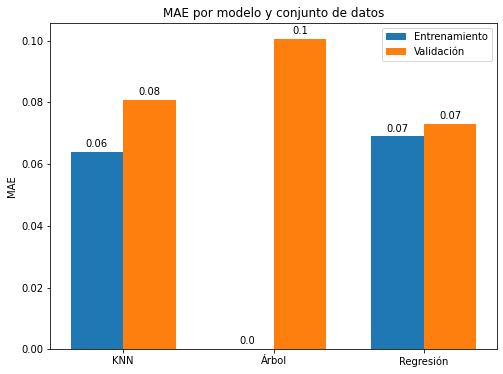

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Crear los datos para los modelos
modelos = ['KNN', 'Árbol', 'Regresión']
mae_entrenamiento = [knn_mae_train, tree_mae_train, reg_mae_train]
mae_validacion = [knn_mae_val, tree_mae_val, reg_mae_val]

# Configurar la figura
fig, ax = plt.subplots(figsize=(8, 6))
ind = np.arange(len(modelos))
ancho = 0.35

# Graficar las barras
rects1 = ax.bar(ind - ancho/2, mae_entrenamiento, ancho, label='Entrenamiento')
rects2 = ax.bar(ind + ancho/2, mae_validacion, ancho, label='Validación')

# Configurar los ejes y la leyenda
ax.set_ylabel('MAE')
ax.set_title('MAE por modelo y conjunto de datos')
ax.set_xticks(ind)
ax.set_xticklabels(modelos)
ax.legend()

# Agregar las etiquetas a las barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Mostrar la gráfica
plt.show()

Como se puede observar a simple vista, el error más pequeño del MAE en train es el del árbol de decisión, este es de 0, lo cual significaría que el modelo se está ajustando perfectamente a las instancias de entrenamiento. Esto se puede deber a un sobreajuste de los datos, debido a que en un árbol de decisión sin una limitación en su profundidad, este se puede expandir hasta que en cada nodo hoja se pueda clasificar cada una de las instancias obteniéndose ese error de 0. Gracias a la obtención del MAE en validación se puede observar como aunque haya entrenado de manera perfecta, no predice correctamente, confirmándose la hipótesis del sobreajuste.

Fuera de este sobreajuste, el KNN obtiene el mejor MAE en train aunque sus predicciones no son del todo precisas. El modelo más equilibrado entre el MAE de entrenamiento y de validación es el de la regresión lineal.

**Gráfica comparativa del RMSE** (train y val)

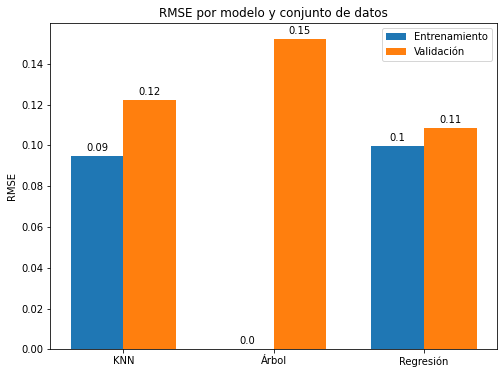

In [ ]:
# Crear los datos para los modelos
modelos = ['KNN', 'Árbol', 'Regresión']
mae_entrenamiento = [knn_rmse_train, tree_rmse_train, reg_rmse_train]
mae_validacion = [knn_rmse_val, tree_rmse_val, reg_rmse_val]

# Configurar la figura
fig, ax = plt.subplots(figsize=(8, 6))
ind = np.arange(len(modelos))
ancho = 0.35

# Graficar las barras
rects1 = ax.bar(ind - ancho/2, mae_entrenamiento, ancho, label='Entrenamiento')
rects2 = ax.bar(ind + ancho/2, mae_validacion, ancho, label='Validación')

# Configurar los ejes y la leyenda
ax.set_ylabel('RMSE')
ax.set_title('RMSE por modelo y conjunto de datos')
ax.set_xticks(ind)
ax.set_xticklabels(modelos)
ax.legend()

# Agregar las etiquetas a las barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Mostrar la gráfica
plt.show()

Los valores obtenidos para el RMSE son bastante similares a los obtenidos con el cálculo del MAE, teniéndo las gráficas formas prácticamente iguales.

**Gráfica comparativa del Tiempo de entrenamiento**

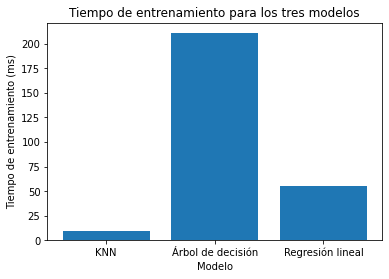

In [ ]:
# Obtener los valores de tiempo de entrenamiento para cada modelo
time_values = df.loc['Tiempo de entrenamiento (ms)']

# Crear un gráfico de barras
fig, ax = plt.subplots()
ax.bar(time_values.index, time_values.values)

# Personalizar el gráfico
ax.set_title('Tiempo de entrenamiento para los tres modelos')
ax.set_xlabel('Modelo')
ax.set_ylabel('Tiempo de entrenamiento (ms)')
plt.show()

Como es observable a simple vista, el modelo que más tarda es el árbol de decisión, esto puede deberse a que el modelo desarrolla una complejidad muy alta debido a la gran profundidad del algoritmo.

El modelo que arroja un menjor resultado en cuanto al tiempo es el del KNN, el cuál mantiene una amplia ventaja frente a la regresión lineal.

## **4.3.OPTIMIZACIÓN DE HIPERPARÁMETROS**




### Modelo KNN

In [ ]:
knn = KNeighborsRegressor()

# Definir cuadrícula de valores de hiperparámetros a explorar
param_grid = {'n_neighbors': [7, 8, 9, 10, 11, 12, 15], 'p': [1, 2]}

# Definir métricas de evaluación a utilizar
#scoring = { 'MAE': make_scorer(mean_absolute_error, greater_is_better=False) }
scoring = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False), 'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}

# Iniciar la medición del tiempo
start_time = time.time()

# Realizar búsqueda exhaustiva de los mejores valores de los hiperparámetros
grid_search = GridSearchCV(knn, param_grid=param_grid, scoring=scoring, refit='MAE', cv=cv)
knn_opt_fit = grid_search.fit(X_train_norm, Y_train_norm)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
reg_training_time = round((end_time - start_time) * 1000, 6)

# Imprimir mejores valores de los hiperparámetros y su rendimiento en términos de MAE y RMSE
print('Mejores valores de hiperparámetros:', grid_search.best_params_)
print('MAE con hiperparámetros optimizados:', grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_] * -1)
print('RMSE con hiperparámetros optimizados:', grid_search.cv_results_['mean_test_RMSE'][grid_search.best_index_] * -1)

knn_opt_mae = grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_] * -1
knn_opt_rmse = grid_search.cv_results_['mean_test_RMSE'][grid_search.best_index_] * -1

Mejores valores de hiperparámetros: {'n_neighbors': 10, 'p': 1}
MAE con hiperparámetros optimizados: 0.07354705493253016
RMSE con hiperparámetros optimizados: 0.10754745773754364


### Modelo Árbol de Decisión

In [ ]:
# Definir el modelo
tree = DecisionTreeRegressor()

# Definir los parámetros a probar
param_grid = {'max_depth': [3, 5, 7, 9], 'min_samples_leaf': [1, 2, 4, 8]}

scoring = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False), 'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}

# Definir la búsqueda por validación cruzada
grid_search = GridSearchCV(tree, param_grid, cv=cv, refit='MAE', scoring=scoring) #'neg_mean_squared_error'

# Entrenar el modelo con los datos de entrenamiento
grid_search.fit(X_train_norm, Y_train_norm)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de entrenamiento
Y_pred = best_model.predict(X_train_norm)

# Calcular el MAE y el RMSE
mae = mean_absolute_error(Y_train_norm, Y_pred)
rmse = math.sqrt(mean_squared_error(Y_train_norm, Y_pred))

# Imprimir los resultados
print("Mejores parámetros: ", best_params)
print("MAE: ", mae)
print("RMSE: ", rmse)

Mejores parámetros:  {'max_depth': 7, 'min_samples_leaf': 4}
MAE:  0.06413775940642182
RMSE:  0.09279913449298238


### Modelo Árbol de Regresión Lineal

## **4.4.COMPARATIVA OPTIMIZACIÓN DE HIPERPARÁMETROS**

## **4.5.COMPARATIVA MODELOS BÁSICOS**

HACER LASSO Y RIDGE

# **5.MODELOS AVANZADOS**

## **5.1.OMISIÓN DE HIPERPARÁMETROS**

### Modelo SVMs 

In [ ]:
# Crear un clasificador SVM sin ajuste de hiperparámetros
clf = SVC(kernel='linear', C=1, random_state=0)

# Entrenar el clasificador en los datos de entrenamiento
clf.fit(X_train, Y_train)

# Hacer predicciones en los datos de entrenamiento
y_pred_train = clf.predict(X_train)

# Calcular el MAE y RMSE en los datos de entrenamiento
mae_train = mean_absolute_error(Y_train, y_pred_train)
rmse_train = mean_squared_error(Y_train, y_pred_train, squared=False)

# Imprimir los resultados
print("MAE en los datos de entrenamiento:", mae_train)
print("RMSE en los datos de entrenamiento:", rmse_train)

### Modelo Random Forests 

In [ ]:
# Crear modelo con los parámetros por defecto
rf = RandomForestRegressor()

# Entrenar el modelo
rf.fit(X_train, Y_train)

# Realizar predicciones en el conjunto de entrenamiento
Y_pred = rf.predict(X_train)

# Calcular el MAE y el RMSE
mae = mean_absolute_error(Y_train, Y_pred)
rmse = math.sqrt(mean_squared_error(Y_train, Y_pred))

# Imprimir los resultados
print("MAE: {:.2f}".format(mae))
print("RMSE: {:.2f}".format(rmse))

## **5.2.COMPARATIVA OMISIÓN DE HIPERPARÁMETROS**

## **5.3.OPTIMIZACIÓN DE HIPERPARÁMETROS**

### Modelo SVMs 

In [ ]:
# Definir los parámetros a optimizar
param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.2, 0.3], 'gamma': ['scale', 'auto']}

# Crear el modelo SVR
svm = SVR()

# Realizar la búsqueda de los mejores parámetros
svm_opt = GridSearchCV(svm, param_grid, scoring='neg_mean_absolute_error', cv=5)
svm_opt.fit(X_train, Y_train)

# Obtener los mejores parámetros
best_params = svm_opt.best_params_
print("Mejores parámetros:", best_params)

# Entrenar el modelo con los mejores parámetros
svm = SVR(**best_params)
svm.fit(X_train, Y_train)

# Realizar predicciones en el conjunto de entrenamiento
Y_pred = svm.predict(X_train)

# Calcular el MAE y el RMSE
mae = mean_absolute_error(Y_train, Y_pred)
rmse = math.sqrt(mean_squared_error(Y_train, Y_pred))

# Imprimir los resultados
print("MAE: {:.2f}".format(mae))
print("RMSE: {:.2f}".format(rmse))

### Modelo Random Forests 

In [ ]:
# Crear modelo de Random Forest
rf = RandomForestRegressor()

# Definir grid de hiperparámetros a evaluar
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Crear objeto GridSearchCV para encontrar los mejores parámetros
grid_rf = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1)

# Entrenar modelo con parámetros optimizados
grid_rf.fit(X_train, Y_train)

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros: ", grid_rf.best_params_)

# Predecir valores para datos de test usando el modelo optimizado
Y_pred = grid_rf.predict(X_train)

# Calcular el MAE y el RMSE
mae = mean_absolute_error(Y_train, Y_pred)
rmse = math.sqrt(mean_squared_error(Y_train, Y_pred))

# Imprimir los resultados
print("MAE: {:.2f}".format(mae))
print("RMSE: {:.2f}".format(rmse))

## **5.4.COMPARATIVA OPTIMIZACIÓN DE HIPERPARÁMETROS**





## **5.5.COMPARATIVA MODELOS AVANZADOS**

# **6.MODELO FINAL**